In [1]:
!pip install pytube openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.7/226.7 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 4.8 MB/s eta 0:00:00


In [2]:
from kaggle_secrets import UserSecretsClient
import subprocess
from pytube import YouTube
import IPython.display as ipd
import cv2
import pandas as pd
import numpy as np

from IPython.display import display, Image, Audio

import cv2  
import base64
import time
from openai import OpenAI
import os
import requests


In [3]:
class CFG:
    model1 = "gpt-4-vision-preview"
    device = 'cuda'
    
    


In [4]:
# Function to encode the image
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

Convert the YT video to a local mp4 file 

In [5]:
YouTube('https://www.youtube.com/shorts/vEptiF_dXHg').streams.get_highest_resolution().download()

'/kaggle/working/I Cant With These Pets!!🤣 🐶 funny dogs pets funnypets afv shorts.mp4'

In [6]:
# setup OpenAI connection
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("openaivision")    
# GPT4-vision setup
client = OpenAI(api_key= secret_value_0)


In [7]:
file_name = !ls

In [8]:
subprocess.run(['ffmpeg', '-i', file_name[0], '-qscale', '0', 'muh_video.mp4', '-loglevel',  'quiet'] )

CompletedProcess(args=['ffmpeg', '-i', 'I Cant With These Pets!!🤣 🐶 funny dogs pets funnypets afv shorts.mp4', '-qscale', '0', 'muh_video.mp4', '-loglevel', 'quiet'], returncode=0)

In [9]:
ipd.Video('muh_video.mp4', width=200)

Get the description of the video

In [10]:
video = cv2.VideoCapture("/kaggle/working/muh_video.mp4")

base64Frames = []
while video.isOpened():
    success, frame = video.read()
    if not success:
        break
    _, buffer = cv2.imencode(".jpg", frame)
    base64Frames.append(base64.b64encode(buffer).decode("utf-8"))

video.release()
print(len(base64Frames), "frames read.")

474 frames read.


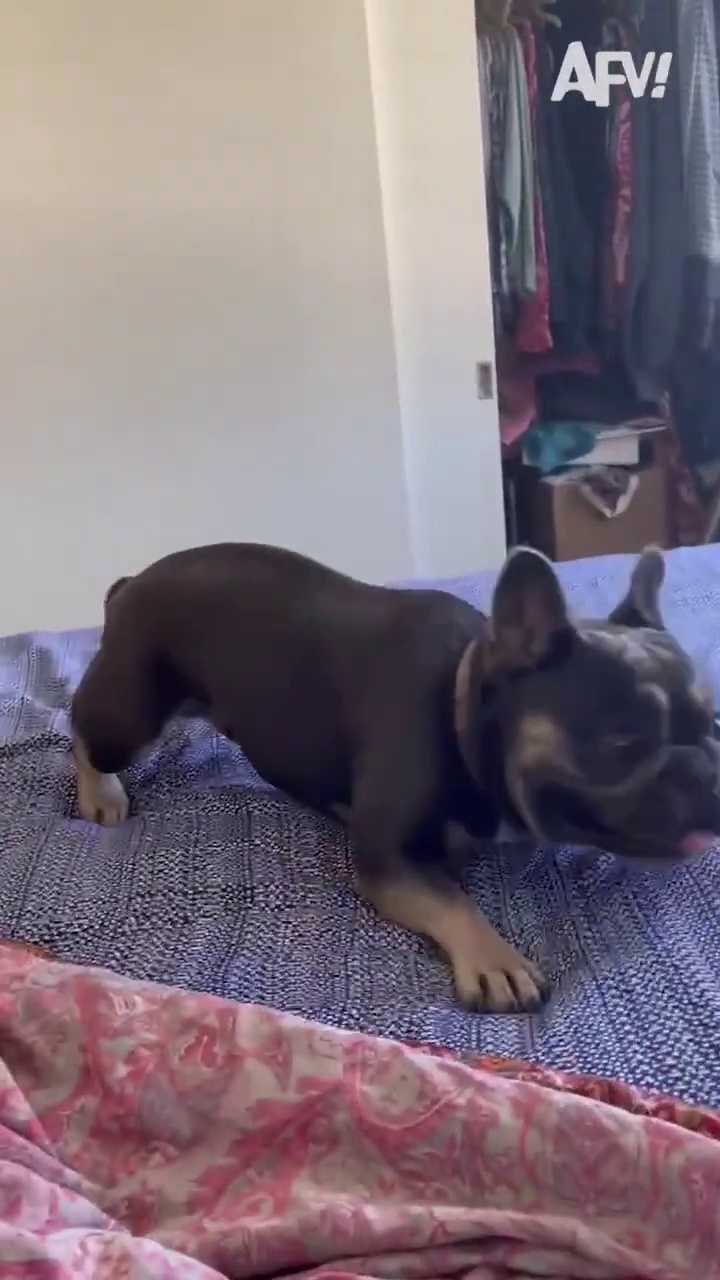

In [11]:
display_handle = display(None, display_id=True)
for img in base64Frames:
    display_handle.update(Image(data=base64.b64decode(img.encode("utf-8"))))
    time.sleep(0.025)

Send a subset of frames to GPT4 using a crafted prompt

In [12]:
PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            "These are frames of a video. Describe what is happening in this video in the style of a BBC nature documentary,\
            in the style of David Attenborough. Only include the narration.",
            *map(lambda x: {"image": x, "resize": 768}, base64Frames[0::300]),
        ],
    },
]


In [13]:

params = {
    "model": "gpt-4-vision-preview",
    "messages": PROMPT_MESSAGES,
    "max_tokens": 250,
}


In [14]:

result = client.chat.completions.create(**params)
print(result.choices[0].message.content)

[Soft instrumental music begins]

In the comfort of a human abode, a majestic cockatoo perches with ruffled feathers beside a grand piano. Observe as it listens intently to the melodious enchantments played by its human companion. In a magnificent display of cross-species interaction, the cockatoo may soon partake in this harmonious affair, tilting its head in a dance orchestrated by the tune's ebb and flow.

[Music swells]

Shifting our gaze to the tranquil waters of a domestic oasis, a golden retriever pup finds serenity aboard a vibrant inflatable flamingo. Enveloped by heart-shaped symbols of affection, the young canine gently bobs upon the water's surface. Here, in this unlikely vessel, the pup embodies the quintessence of leisure, a testament to the delightful synergies created when the natural and synthetic worlds intertwine.

[Music fades out]

And so, we are reminded of the extraordinary bond that forms between the myriad creatures of our planet and the human artisans of comfo

create a voiceover

In [15]:
# avoid violating API rate limits
time.sleep(65)

In [16]:
response = requests.post(
    "https://api.openai.com/v1/audio/speech",
    headers={
        "Authorization": f"Bearer {secret_value_0}",
    },
    json={
        "model": "tts-1-1106",
        "input": result.choices[0].message.content,
        "voice": "onyx",
    },
)

audio = b""
for chunk in response.iter_content(chunk_size=1024 * 1024):
    audio += chunk
Audio(audio)